<a href="https://colab.research.google.com/github/maurofama99/ann_challenge/blob/main/ANN_challenge1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SetUp

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive/ANN/data2

/gdrive/My Drive/ANN/data2


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# Load the dataset to be used for classification
!unzip training_dataset_homework1.zip

In [ ]:
# Dataset folders 
dataset_dir = 'training_data_final'


In [ ]:
#get the number of img of each species
import fnmatch

count = [0,0,0,0,0,0,0,0]
labels = ['Species1',       # 0
          'Species2',       # 1
          'Species3',       # 2
          'Species4',       # 3
          'Species5',       # 4
          'Species6',       # 5
          'Species7',       # 6
          'Species8']       # 7

for i in range(len(labels)):
  dir_path = os.path.join(dataset_dir, labels[i])
  count[i] = len(fnmatch.filter(os.listdir(dir_path), '*.*'))
  print('The number of img of', labels[i], 'is: ', count[i])

cumsum = np.cumsum(count)
print('Total amount of img is: ', cumsum[len(cumsum)-1] )

The number of img of Species1 is:  186
The number of img of Species2 is:  532
The number of img of Species3 is:  515
The number of img of Species4 is:  511
The number of img of Species5 is:  531
The number of img of Species6 is:  222
The number of img of Species7 is:  537
The number of img of Species8 is:  508
Total amount of img is:  3542


In [ ]:
"Given functions"
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm


def plot_confusionMatrix(test_labels, test_predicted):
  cm = confusion_matrix(test_labels, test_predicted, labels=[0,1,2,3,4,5,6,7])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=labels)
  disp.plot()
  plt.show()
  return 


In [ ]:
def testModel( valid_gen, model):

  # d. Predit test labels
  test_predicted = model.predict(valid_gen)
  test_predicted = np.argmax(test_predicted, axis=-1)
  

  # e. plot confusion matrix
  plot_confusionMatrix(valid_gen.classes, test_predicted)

  # f. display classification results
  print(classification_report(valid_gen.classes, test_predicted, target_names=labels))

In [ ]:
import cv2

def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 70
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

def change_color(image):
    image = np.array(image)
    hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    return hsv_image

def preprocessing(image):
    CP1 = 0.3
    CP2 = 0.6
    n = random.random()
    if n<=CP1: 
        return change_color(image)
    elif n>CP1 and n<=CP2:
        return add_noise(image)
    return image

In [ ]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with Data Augmentation
data_gen = ImageDataGenerator(rescale=1/255, validation_split=0.2) 

aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        #preprocessing_function=preprocessing,
                                        rescale=1/255,
                                        validation_split=0.2)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = aug_train_data_gen.flow_from_directory(directory=dataset_dir,
                                                           target_size=(96,96),
                                                           color_mode='rgb',
                                                           classes=None, # can be set to labels
                                                           class_mode='categorical',
                                                           batch_size=32,
                                                           shuffle=True,
                                                           seed=seed,
                                                           subset="training")

valid_gen = data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=1,
                                               shuffle=False,
                                               seed=seed,
                                               subset="validation")

Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


In [ ]:
input_shape = (96, 96, 3)
epochs = 200

##Build Model

In [ ]:
def build_model(input_shape, supernet):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    vgg16_layer = supernet(input_layer) 

    flattening_layer = tfkl.Flatten(name='Flatten')(vgg16_layer)

    layer1 = tfkl.Dense(units=1028, kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(flattening_layer)

    dropout1 = tfkl.Dropout(0.3, seed=seed)(layer1)

    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(dropout1)

    dropout2 = tfkl.Dropout(0.3, seed=seed)(classifier_layer)

    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

In [ ]:
def build_model2(input_shape, supernet):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    vgg16_layer = supernet(input_layer) 

    flattening_layer = tfkl.Flatten(name='Flatten')(vgg16_layer)

    layer1 = tfkl.Dense(units=1028, kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(flattening_layer)

    dropout1 = tfkl.Dropout(0.3, seed=seed)(layer1)

    classifier_layer = tfkl.Dense(units=1028, name='Classifier', kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(dropout1)

    dropout2 = tfkl.Dropout(0.3, seed=seed)(classifier_layer)

    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

In [ ]:
def build_model3(input_shape, supernet):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    vgg16_layer = supernet(input_layer) 

    flattening_layer = tfkl.Flatten(name='Flatten')(vgg16_layer)

    layer1 = tfkl.Dense(units=512, kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(flattening_layer)

    dropout1 = tfkl.Dropout(0.2, seed=seed)(layer1)

    classifier_layer = tfkl.Dense(units=256, name='Classifier', kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(dropout1)

    dropout2 = tfkl.Dropout(0.5, seed=seed)(classifier_layer)

    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics='accuracy')

    # Return the model
    return model

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

#VGG16

In [ ]:
# Download and plot the VGG16 model
supernet1 = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

In [ ]:
for layer in supernet1.layers:
    layer.trainable = False

In [ ]:
# Build model and visualize it
model = build_model2(input_shape, supernet1)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 1028)              4738052   
                                                                 
 dropout_4 (Dropout)         (None, 1028)              0         
                                                                 
 Classifier (Dense)          (None, 1028)              1057812   
                                                                 
 dropout_5 (Dropout)         (None, 1028)              0     

In [ ]:
# Create folders and callbacks and fit
callbacks = create_folders_and_callbacks(model_name='CNN_VGG16_1')

# Train the model
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 21s 228ms/step - loss: 15.6023 - accuracy: 0.2578 - val_loss: 1.4858 - val_accuracy: 0.4249
Epoch 2/200
89/89 [==============================] - 21s 231ms/step - loss: 13.1086 - accuracy: 0.3688 - val_loss: 1.4027 - val_accuracy: 0.4334
Epoch 3/200
89/89 [==============================] - 20s 224ms/step - loss: 12.2057 - accuracy: 0.4140 - val_loss: 1.2996 - val_accuracy: 0.5057
Epoch 4/200
89/89 [==============================] - 20s 228ms/step - loss: 11.9261 - accuracy: 0.4404 - val_loss: 1.2696 - val_accuracy: 0.5326
Epoch 5/200
89/89 [==============================] - 21s 235ms/step - loss: 11.3703 - accuracy: 0.4795 - val_loss: 1.2560 - val_accuracy: 0.5198
Epoch 6/200
89/89 [==============================] - 21s 236ms/step - loss: 11.4674 - accuracy: 0.4630 - val_loss: 1.2163 - val_accuracy: 0.5326
Epoch 7/200
89/89 [==============================] - 20s 229ms/step - loss: 11.0776 - accuracy: 0.4725 - val_loss: 1.1592 - val_ac

In [ ]:
# Save best epoch model
model.save("savedModels/CNN_VGG16_1")

In [ ]:
testModel(valid_gen, model)

In [ ]:
m = tfk.models.load_model("savedModels/CNN_VGG16_1")

In [ ]:
m.get_layer('vgg16').trainable = True

In [ ]:
m.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
m.summary()

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_VGG16_1_FineTuning')

# Train the model
history = m.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

In [ ]:
# Save best epoch model
m.save("savedModels/CNN_VGG16_1_FineTuning")

706/706 [==============================] - 4s 6ms/step


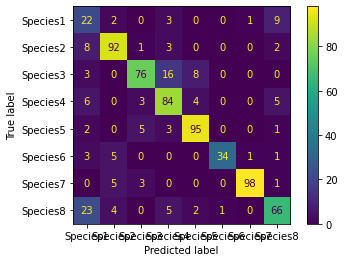

              precision    recall  f1-score   support

    Species1       0.33      0.59      0.42        37
    Species2       0.85      0.87      0.86       106
    Species3       0.86      0.74      0.80       103
    Species4       0.74      0.82      0.78       102
    Species5       0.87      0.90      0.88       106
    Species6       0.97      0.77      0.86        44
    Species7       0.98      0.92      0.95       107
    Species8       0.78      0.65      0.71       101

    accuracy                           0.80       706
   macro avg       0.80      0.78      0.78       706
weighted avg       0.83      0.80      0.81       706



In [ ]:
testModel(valid_gen, m)

build_model (1028, 512)
lr Dropout : 0.3 0.3
batch size = 32

In [ ]:
testModel(valid_gen, m)

build_model2 (1028, 1028) \\
lr Dropout : 0.3 0.3 \\
batch size = 32

706/706 [==============================] - 5s 7ms/step


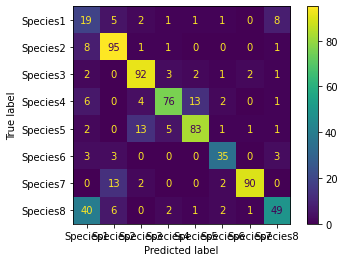

              precision    recall  f1-score   support

    Species1       0.24      0.51      0.32        37
    Species2       0.78      0.90      0.83       106
    Species3       0.81      0.89      0.85       103
    Species4       0.86      0.75      0.80       102
    Species5       0.83      0.78      0.81       106
    Species6       0.80      0.80      0.80        44
    Species7       0.96      0.84      0.90       107
    Species8       0.77      0.49      0.59       101

    accuracy                           0.76       706
   macro avg       0.75      0.74      0.74       706
weighted avg       0.80      0.76      0.77       706



In [ ]:
testModel(valid_gen, m)

build_model3 (516, 228) \\
lr Dropout_ 0.2 0.5 \\
batch size= 32

In [ ]:
m2 = tfk.models.load_model("savedModels/CNN_VGG16_1_FineTuning")

In [ ]:
m2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')
m2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 512)               2359808   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_VGG16_2_FineTuning')

# Train the model
history = m2.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 23s 245ms/step - loss: 5.1453 - accuracy: 0.7683 - val_loss: 0.6391 - val_accuracy: 0.7408
Epoch 2/200
89/89 [==============================] - 20s 229ms/step - loss: 4.6304 - accuracy: 0.7831 - val_loss: 0.6252 - val_accuracy: 0.7550
Epoch 3/200
89/89 [==============================] - 22s 252ms/step - loss: 4.6292 - accuracy: 0.7860 - val_loss: 0.6293 - val_accuracy: 0.7479
Epoch 4/200
89/89 [==============================] - 21s 235ms/step - loss: 4.4074 - accuracy: 0.8015 - val_loss: 0.7229 - val_accuracy: 0.7167
Epoch 5/200
89/89 [==============================] - 22s 248ms/step - loss: 4.4316 - accuracy: 0.7860 - val_loss: 0.6115 - val_accuracy: 0.7436
Epoch 6/200
89/89 [==============================] - 21s 234ms/step - loss: 4.3978 - accuracy: 0.8004 - val_loss: 0.7477 - val_accuracy: 0.7054
Epoch 7/200
89/89 [==============================] - 21s 232ms/step - loss: 4.4012 - accuracy: 0.8001 - val_loss: 0.5871 - val_accuracy:

In [ ]:
# Save best epoch model
m2.save("savedModels/CNN_VGG16_2_FineTuning")

706/706 [==============================] - 4s 6ms/step


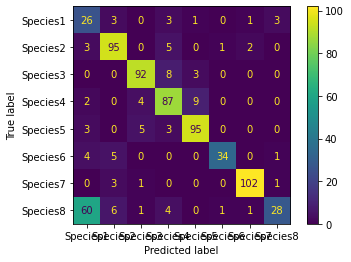

              precision    recall  f1-score   support

    Species1       0.27      0.70      0.39        37
    Species2       0.85      0.90      0.87       106
    Species3       0.89      0.89      0.89       103
    Species4       0.79      0.85      0.82       102
    Species5       0.88      0.90      0.89       106
    Species6       0.94      0.77      0.85        44
    Species7       0.96      0.95      0.96       107
    Species8       0.85      0.28      0.42       101

    accuracy                           0.79       706
   macro avg       0.80      0.78      0.76       706
weighted avg       0.84      0.79      0.79       706



In [ ]:
testModel(valid_gen, m2)

In [ ]:
m3 = tfk.models.load_model("savedModels/CNN_VGG16_2_FineTuning")

In [ ]:
m3.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-6), metrics='accuracy')
m3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 512)               2359808   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_VGG16_3_FineTuning')

# Train the model
history = m3.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 21s 230ms/step - loss: 3.7567 - accuracy: 0.8170 - val_loss: 0.5789 - val_accuracy: 0.7748
Epoch 2/200
89/89 [==============================] - 22s 242ms/step - loss: 3.8303 - accuracy: 0.8205 - val_loss: 0.5809 - val_accuracy: 0.7748
Epoch 3/200
89/89 [==============================] - 21s 238ms/step - loss: 3.7809 - accuracy: 0.8212 - val_loss: 0.6016 - val_accuracy: 0.7649
Epoch 4/200
89/89 [==============================] - 22s 250ms/step - loss: 3.8649 - accuracy: 0.8166 - val_loss: 0.6148 - val_accuracy: 0.7592
Epoch 5/200
89/89 [==============================] - 21s 241ms/step - loss: 3.8709 - accuracy: 0.8198 - val_loss: 0.5935 - val_accuracy: 0.7720
Epoch 6/200
89/89 [==============================] - 21s 238ms/step - loss: 3.6720 - accuracy: 0.8304 - val_loss: 0.5908 - val_accuracy: 0.7649
Epoch 7/200
89/89 [==============================] - 22s 251ms/step - loss: 3.6687 - accuracy: 0.8251 - val_loss: 0.5749 - val_accuracy:

In [ ]:
# Save best epoch model
m3.save("savedModels/CNN_VGG16_3_FineTuning")

706/706 [==============================] - 4s 5ms/step


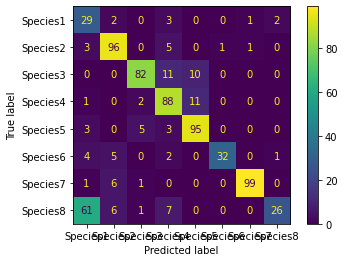

              precision    recall  f1-score   support

    Species1       0.28      0.78      0.42        37
    Species2       0.83      0.91      0.87       106
    Species3       0.90      0.80      0.85       103
    Species4       0.74      0.86      0.80       102
    Species5       0.82      0.90      0.86       106
    Species6       0.97      0.73      0.83        44
    Species7       0.98      0.93      0.95       107
    Species8       0.90      0.26      0.40       101

    accuracy                           0.77       706
   macro avg       0.80      0.77      0.75       706
weighted avg       0.84      0.77      0.77       706



In [ ]:
testModel(valid_gen, m3)

In [ ]:
m4 = tfk.models.load_model("savedModels/CNN_VGG16_3_FineTuning")

In [ ]:
m4.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-7), metrics='accuracy')
m4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 512)               2359808   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_VGG16_4_FineTuning')

# Train the model
history = m4.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 22s 234ms/step - loss: 3.8032 - accuracy: 0.8138 - val_loss: 0.5771 - val_accuracy: 0.7776
Epoch 2/200
89/89 [==============================] - 22s 242ms/step - loss: 3.7699 - accuracy: 0.8166 - val_loss: 0.5798 - val_accuracy: 0.7720
Epoch 3/200
89/89 [==============================] - 22s 251ms/step - loss: 3.8292 - accuracy: 0.8145 - val_loss: 0.5855 - val_accuracy: 0.7705
Epoch 4/200
89/89 [==============================] - 21s 238ms/step - loss: 3.7684 - accuracy: 0.8177 - val_loss: 0.5905 - val_accuracy: 0.7663
Epoch 5/200
89/89 [==============================] - 21s 237ms/step - loss: 3.9205 - accuracy: 0.8184 - val_loss: 0.5874 - val_accuracy: 0.7705
Epoch 6/200
89/89 [==============================] - 22s 250ms/step - loss: 3.8791 - accuracy: 0.8202 - val_loss: 0.5875 - val_accuracy: 0.7691
Epoch 7/200
89/89 [==============================] - 21s 237ms/step - loss: 3.9275 - accuracy: 0.8209 - val_loss: 0.5853 - val_accuracy:

In [ ]:
# Save best epoch model
m4.save("savedModels/CNN_VGG16_4_FineTuning")

706/706 [==============================] - 4s 5ms/step


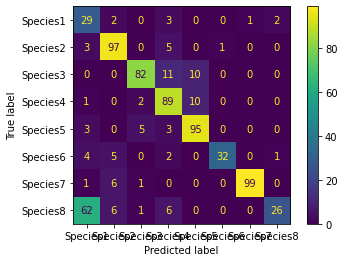

              precision    recall  f1-score   support

    Species1       0.28      0.78      0.41        37
    Species2       0.84      0.92      0.87       106
    Species3       0.90      0.80      0.85       103
    Species4       0.75      0.87      0.81       102
    Species5       0.83      0.90      0.86       106
    Species6       0.97      0.73      0.83        44
    Species7       0.99      0.93      0.96       107
    Species8       0.90      0.26      0.40       101

    accuracy                           0.78       706
   macro avg       0.81      0.77      0.75       706
weighted avg       0.84      0.78      0.78       706



In [ ]:
testModel(valid_gen, m4)

#XCeption

In [ ]:
supernet2 = tfk.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

83683744/83683744 [==============================] - 4s 0us/step


In [ ]:
for layer in supernet2.layers:
    layer.trainable = False

In [ ]:
xCeption = build_model3(input_shape, supernet2)
xCeption.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 Flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense_1 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_XCeption')

# Train the model
history = xCeption.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 30s 310ms/step - loss: 17.5881 - accuracy: 0.2482 - val_loss: 1.7035 - val_accuracy: 0.3810
Epoch 2/200
89/89 [==============================] - 27s 300ms/step - loss: 14.9561 - accuracy: 0.3166 - val_loss: 1.5201 - val_accuracy: 0.4462
Epoch 3/200
89/89 [==============================] - 26s 296ms/step - loss: 14.0343 - accuracy: 0.3484 - val_loss: 1.4753 - val_accuracy: 0.4462
Epoch 4/200
89/89 [==============================] - 28s 321ms/step - loss: 13.4627 - accuracy: 0.3791 - val_loss: 1.4683 - val_accuracy: 0.4221
Epoch 5/200
89/89 [==============================] - 26s 291ms/step - loss: 13.3831 - accuracy: 0.3812 - val_loss: 1.4386 - val_accuracy: 0.4476
Epoch 6/200
89/89 [==============================] - 27s 305ms/step - loss: 13.0694 - accuracy: 0.4080 - val_loss: 1.3990 - val_accuracy: 0.4844
Epoch 7/200
89/89 [==============================] - 26s 295ms/step - loss: 12.6067 - accuracy: 0.4189 - val_loss: 1.4538 - val_ac

KeyboardInterrupt: ignored

In [ ]:
# Save best epoch model
xCeption.save("savedModels/CNN_XCeption")

In [ ]:
testModel(valid_gen, xCeption)

706/706 [==============================] - 7s 9ms/step


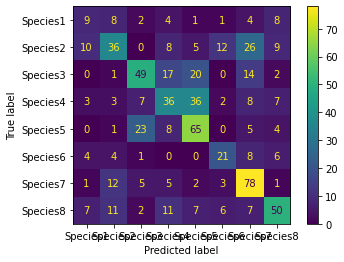

              precision    recall  f1-score   support

    Species1       0.26      0.24      0.25        37
    Species2       0.47      0.34      0.40       106
    Species3       0.55      0.48      0.51       103
    Species4       0.40      0.35      0.38       102
    Species5       0.48      0.61      0.54       106
    Species6       0.47      0.48      0.47        44
    Species7       0.52      0.73      0.61       107
    Species8       0.57      0.50      0.53       101

    accuracy                           0.49       706
   macro avg       0.47      0.47      0.46       706
weighted avg       0.49      0.49      0.48       706



In [ ]:
testModel(valid_gen, xCeption) #with roumor

706/706 [==============================] - 6s 8ms/step


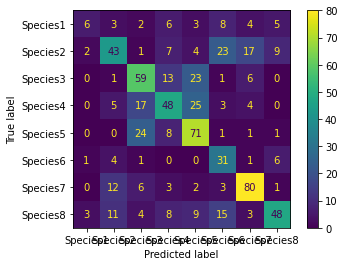

              precision    recall  f1-score   support

    Species1       0.50      0.16      0.24        37
    Species2       0.54      0.41      0.46       106
    Species3       0.52      0.57      0.54       103
    Species4       0.52      0.47      0.49       102
    Species5       0.52      0.67      0.58       106
    Species6       0.36      0.70      0.48        44
    Species7       0.69      0.75      0.72       107
    Species8       0.69      0.48      0.56       101

    accuracy                           0.55       706
   macro avg       0.54      0.53      0.51       706
weighted avg       0.56      0.55      0.54       706



In [ ]:
#this is with roumor in the imgs
testModel(valid_gen, xCeption)

In [ ]:
xc = tfk.models.load_model("savedModels/CNN_XCeption")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 Flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [ ]:
xc.get_layer('xception').trainable = True

In [ ]:
xc.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
xc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 Flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_XCeption_1_FineTuning')

# Train the model
history = xc.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 44s 418ms/step - loss: 15.4782 - accuracy: 0.2405 - val_loss: 1.6241 - val_accuracy: 0.4037
Epoch 2/200
89/89 [==============================] - 32s 363ms/step - loss: 14.3611 - accuracy: 0.3071 - val_loss: 1.3370 - val_accuracy: 0.5014
Epoch 3/200
89/89 [==============================] - 31s 354ms/step - loss: 13.5145 - accuracy: 0.3628 - val_loss: 1.3018 - val_accuracy: 0.5028
Epoch 4/200
89/89 [==============================] - 30s 336ms/step - loss: 13.5222 - accuracy: 0.3547 - val_loss: 1.1803 - val_accuracy: 0.5581
Epoch 5/200
89/89 [==============================] - 31s 352ms/step - loss: 13.0123 - accuracy: 0.3787 - val_loss: 1.1049 - val_accuracy: 0.6232
Epoch 6/200
89/89 [==============================] - 33s 373ms/step - loss: 12.6746 - accuracy: 0.4136 - val_loss: 1.2643 - val_accuracy: 0.5992
Epoch 7/200
89/89 [==============================] - 31s 351ms/step - loss: 12.2222 - accuracy: 0.4203 - val_loss: 1.0989 - val_ac

In [ ]:
# Save best epoch model
xc.save("savedModels/CNN_XCeption_1_FineTuning")

706/706 [==============================] - 8s 11ms/step


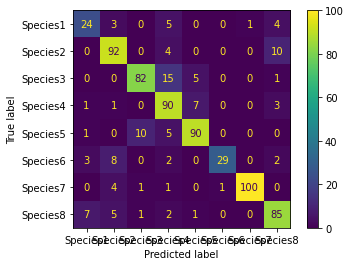

              precision    recall  f1-score   support

    Species1       0.67      0.65      0.66        37
    Species2       0.81      0.87      0.84       106
    Species3       0.87      0.80      0.83       103
    Species4       0.73      0.88      0.80       102
    Species5       0.87      0.85      0.86       106
    Species6       0.97      0.66      0.78        44
    Species7       0.99      0.93      0.96       107
    Species8       0.81      0.84      0.83       101

    accuracy                           0.84       706
   macro avg       0.84      0.81      0.82       706
weighted avg       0.85      0.84      0.84       706



In [ ]:
testModel(valid_gen, xc)

706/706 [==============================] - 7s 8ms/step


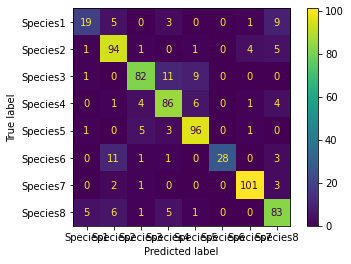

              precision    recall  f1-score   support

    Species1       0.70      0.51      0.59        37
    Species2       0.79      0.89      0.84       106
    Species3       0.86      0.80      0.83       103
    Species4       0.79      0.84      0.82       102
    Species5       0.85      0.91      0.88       106
    Species6       1.00      0.64      0.78        44
    Species7       0.94      0.94      0.94       107
    Species8       0.78      0.82      0.80       101

    accuracy                           0.83       706
   macro avg       0.84      0.79      0.81       706
weighted avg       0.84      0.83      0.83       706



In [ ]:
testModel(valid_gen, xc)

706/706 [==============================] - 398s 554ms/step


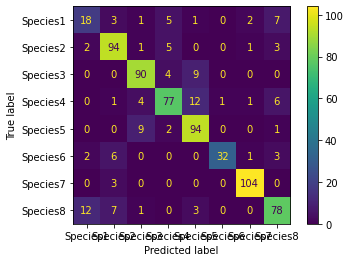

              precision    recall  f1-score   support

    Species1       0.53      0.49      0.51        37
    Species2       0.82      0.89      0.85       106
    Species3       0.85      0.87      0.86       103
    Species4       0.83      0.75      0.79       102
    Species5       0.79      0.89      0.84       106
    Species6       0.97      0.73      0.83        44
    Species7       0.95      0.97      0.96       107
    Species8       0.80      0.77      0.78       101

    accuracy                           0.83       706
   macro avg       0.82      0.80      0.80       706
weighted avg       0.83      0.83      0.83       706



In [ ]:
testModel(valid_gen, xc) #with roumors

In [ ]:
xc2 = tfk.models.load_model("savedModels/CNN_XCeption_1_FineTuning")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 Flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [ ]:
xc2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 Flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_XCeption_2_FineTuning')

# Train the model
history = xc2.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 1485s 17s/step - loss: 6.8598 - accuracy: 0.7070 - val_loss: 0.4807 - val_accuracy: 0.8385
Epoch 2/200
89/89 [==============================] - 29s 328ms/step - loss: 7.0714 - accuracy: 0.6869 - val_loss: 0.4764 - val_accuracy: 0.8300
Epoch 3/200
89/89 [==============================] - 29s 329ms/step - loss: 6.7882 - accuracy: 0.7123 - val_loss: 0.4996 - val_accuracy: 0.8272
Epoch 4/200
89/89 [==============================] - 28s 319ms/step - loss: 7.1253 - accuracy: 0.6961 - val_loss: 0.4877 - val_accuracy: 0.8272
Epoch 5/200
89/89 [==============================] - 28s 310ms/step - loss: 6.9024 - accuracy: 0.7077 - val_loss: 0.4942 - val_accuracy: 0.8314
Epoch 6/200
89/89 [==============================] - 28s 319ms/step - loss: 6.6702 - accuracy: 0.7098 - val_loss: 0.4952 - val_accuracy: 0.8314
Epoch 7/200
89/89 [==============================] - 29s 324ms/step - loss: 6.7454 - accuracy: 0.7042 - val_loss: 0.4892 - val_accuracy:

In [ ]:
# Save best epoch model
xc2.save("savedModels/CNN_XCeption_2_FineTuning")

706/706 [==============================] - 7s 9ms/step


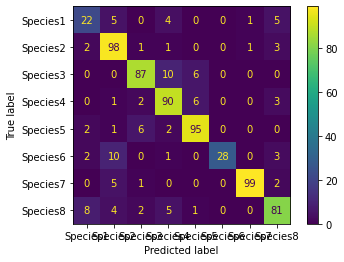

              precision    recall  f1-score   support

    Species1       0.61      0.59      0.60        37
    Species2       0.79      0.92      0.85       106
    Species3       0.88      0.84      0.86       103
    Species4       0.80      0.88      0.84       102
    Species5       0.88      0.90      0.89       106
    Species6       1.00      0.64      0.78        44
    Species7       0.98      0.93      0.95       107
    Species8       0.84      0.80      0.82       101

    accuracy                           0.85       706
   macro avg       0.85      0.81      0.82       706
weighted avg       0.86      0.85      0.85       706



In [ ]:
testModel(valid_gen, xc2)

706/706 [==============================] - 6s 8ms/step


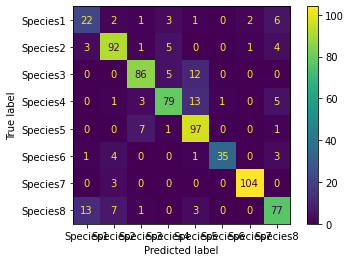

              precision    recall  f1-score   support

    Species1       0.56      0.59      0.58        37
    Species2       0.84      0.87      0.86       106
    Species3       0.87      0.83      0.85       103
    Species4       0.85      0.77      0.81       102
    Species5       0.76      0.92      0.83       106
    Species6       0.97      0.80      0.88        44
    Species7       0.97      0.97      0.97       107
    Species8       0.80      0.76      0.78       101

    accuracy                           0.84       706
   macro avg       0.83      0.81      0.82       706
weighted avg       0.84      0.84      0.84       706



In [ ]:
testModel(valid_gen, xc2) #with roumors

In [ ]:
xc3 = tfk.models.load_model("savedModels/CNN_XCeption_2_FineTuning")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 Flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense_1 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0     

In [ ]:
xc3.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-6), metrics='accuracy')


In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_XCeption_3_FineTuning')

# Train the model
history = xc3.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 38s 365ms/step - loss: 2.1646 - accuracy: 0.9006 - val_loss: 0.5932 - val_accuracy: 0.8442
Epoch 2/200
89/89 [==============================] - 28s 310ms/step - loss: 2.1868 - accuracy: 0.9051 - val_loss: 0.5902 - val_accuracy: 0.8414
Epoch 3/200
89/89 [==============================] - 28s 320ms/step - loss: 2.2359 - accuracy: 0.9090 - val_loss: 0.5860 - val_accuracy: 0.8442
Epoch 4/200
89/89 [==============================] - 28s 316ms/step - loss: 2.3914 - accuracy: 0.9034 - val_loss: 0.5962 - val_accuracy: 0.8385
Epoch 5/200
89/89 [==============================] - 27s 306ms/step - loss: 2.2832 - accuracy: 0.9044 - val_loss: 0.5893 - val_accuracy: 0.8399
Epoch 6/200
89/89 [==============================] - 27s 303ms/step - loss: 2.4685 - accuracy: 0.9006 - val_loss: 0.5973 - val_accuracy: 0.8414
Epoch 7/200
89/89 [==============================] - 27s 302ms/step - loss: 2.1872 - accuracy: 0.9044 - val_loss: 0.5862 - val_accuracy:

In [ ]:
# Save best epoch model
xc3.save("savedModels/CNN_XCeption_3_FineTuning")

706/706 [==============================] - 7s 9ms/step


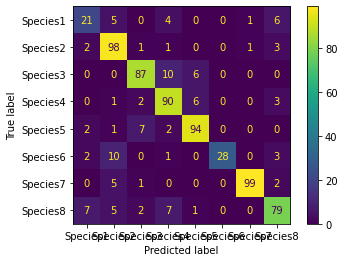

              precision    recall  f1-score   support

    Species1       0.62      0.57      0.59        37
    Species2       0.78      0.92      0.85       106
    Species3       0.87      0.84      0.86       103
    Species4       0.78      0.88      0.83       102
    Species5       0.88      0.89      0.88       106
    Species6       1.00      0.64      0.78        44
    Species7       0.98      0.93      0.95       107
    Species8       0.82      0.78      0.80       101

    accuracy                           0.84       706
   macro avg       0.84      0.81      0.82       706
weighted avg       0.85      0.84      0.84       706



In [ ]:
testModel(valid_gen, xc3)

#InceptionV3

In [ ]:
supernet3 = tfk.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
for layer in supernet3.layers:
    layer.trainable = False

In [ ]:
inceptionV3 = build_model(input_shape, supernet3)
inceptionV3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 Flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1028)              2106372   
                                                                 
 dropout_2 (Dropout)         (None, 1028)              0         
                                                                 
 Classifier (Dense)          (None, 512)               526848    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_XCeption')

# Train the model
history = inceptionV3.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 38s 373ms/step - loss: 18.4904 - accuracy: 0.1668 - val_loss: 1.8235 - val_accuracy: 0.3513
Epoch 2/200
89/89 [==============================] - 30s 341ms/step - loss: 16.1028 - accuracy: 0.2574 - val_loss: 1.7706 - val_accuracy: 0.3456
Epoch 3/200
89/89 [==============================] - 28s 315ms/step - loss: 15.0425 - accuracy: 0.3032 - val_loss: 1.6819 - val_accuracy: 0.3697
Epoch 4/200
89/89 [==============================] - 29s 322ms/step - loss: 14.6979 - accuracy: 0.3029 - val_loss: 1.5911 - val_accuracy: 0.4391
Epoch 5/200
89/89 [==============================] - 28s 311ms/step - loss: 14.3209 - accuracy: 0.3170 - val_loss: 1.5698 - val_accuracy: 0.4207
Epoch 6/200
89/89 [==============================] - 28s 322ms/step - loss: 14.2124 - accuracy: 0.3410 - val_loss: 1.5835 - val_accuracy: 0.4136
Epoch 7/200
89/89 [==============================] - 28s 319ms/step - loss: 14.1402 - accuracy: 0.3325 - val_loss: 1.5390 - val_ac

In [ ]:
# Save best epoch model
inceptionV3.save("savedModels/CNN_inceptionV3")

In [ ]:
testModel(valid_gen, inceptionV3)

In [ ]:
iv3 = tfk.models.load_model("savedModels/CNN_inceptionV3")
iv3.summary()

In [ ]:
iv3.get_layer('inception_v3').trainable = True


In [ ]:
iv3.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
iv3.summary()

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_inceptionV3_FineTuning')

# Train the model
history = iv3.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

In [ ]:
iv3.save("savedModels/CNN_inceptionV3_FineTuning")

In [ ]:
testModel(valid_gen, iv3)

#ResNet

In [ ]:
supernet4 = tfk.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

In [ ]:
for layer in supernet4.layers:
    layer.trainable = False

In [ ]:
resNet = build_model(input_shape, supernet4)
resNet.summary()

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_resNet50')

# Train the model
history = resNet.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

In [ ]:
# Save best epoch model
resNet.save("savedModels/CNN_resNet50")

In [ ]:
testModel(valid_gen, resNet)

In [ ]:
rn = tfk.models.load_model("savedModels/CNN_resNet50")
rn.summary()

In [ ]:
rn.get_layer('xception').trainable = True

In [ ]:
rn.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
rn.summary()

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_resNet50_FineTuning')

# Train the model
history = rn.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

In [ ]:
# Save best epoch model
rn.save("savedModels/CNN_resNet50_FineTuning")

In [ ]:
testModel(valid_gen, rn)

#EfficientNetB4

In [ ]:
supernet5 = tfk.applications.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

In [ ]:
for layer in supernet5.layers:
    layer.trainable = False

In [ ]:
effNetB4 = build_model(input_shape, supernet5)
effNetB4.summary()
tfk.utils.plot_model(effNetB4)

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_effNetB4')

# Train the model
history = effNetB4.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

In [ ]:
# Save best epoch model
effNetB4.save("savedModels/CNN_effNetB4")

In [ ]:
testModel(valid_gen, effNetB4)

In [ ]:
enb4 = tfk.models.load_model("savedModels/CNN_effNetB4")
enb4.summary()

In [ ]:
enb4.get_layer('xception').trainable = True

In [ ]:
enb4.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
enb4.summary()

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_effNetB4_FineTuning')

# Train the model
history = enb4.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

In [ ]:
# Save best epoch model
enb4.save("savedModels/CNN_effNetB4_FineTuning")

In [ ]:
testModel(valid_gen, enb4)

#Combine 2 model together

In [ ]:
first_model = tfk.models.load_model("savedModels/BestModel_1")
second_model = tfk.models.load_model("savedModels/CNN_XCeption_3_FineTuning")

first_model._name = 'model1'
second_model._name = 'model2'

In [ ]:
models = [first_model, second_model]
model_input = tf.keras.Input(shape=input_shape, name='input_layer')
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 model1 (Functional)            (None, 8)            17207880    ['input_layer[0][0]']            
                                                                                                  
 model2 (Functional)            (None, 8)            30432560    ['input_layer[0][0]']            
                                                                                                  
 average (Average)              (None, 8)            0           ['model1[0][0]',                 
                                                                  'model2[0][0]']             

In [ ]:
def build_combine_model(input_shape):
  input_layer = tfkl.Input(shape=input_shape, name='input_layer')

  a = (input_layer/255)
  b = tf.keras.applications.mobilenet.preprocess_input(input_layer)

  x = first_model(a)
  y = second_model(a)

  avg = tf.keras.layers.Average()([x, y])

  combine_model = tfk.Model(inputs=input_layer, outputs=avg, name='Comb_model')

  return combine_model

In [ ]:
cmb_model = build_combine_model(input_shape)
cmb_model.summary()

Model: "Comb_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 96, 96, 3)    0           ['input_layer[0][0]']            
                                                                                                  
 model1 (Functional)            (None, 8)            17207880    ['tf.math.truediv[0][0]']        
                                                                                                  
 model2 (Functional)            (None, 8)            30432560    ['tf.math.truediv[0][0]']        
                                                                                         

In [ ]:
ensemble_model.save("savedModels/EnsambleModel_2")

706/706 [==============================] - 278s 394ms/step


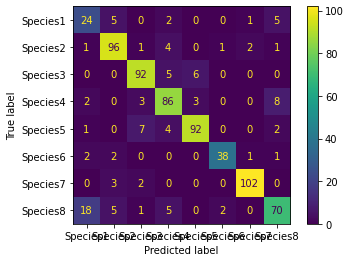

              precision    recall  f1-score   support

    Species1       0.50      0.65      0.56        37
    Species2       0.86      0.91      0.88       106
    Species3       0.87      0.89      0.88       103
    Species4       0.81      0.84      0.83       102
    Species5       0.91      0.87      0.89       106
    Species6       0.93      0.86      0.89        44
    Species7       0.96      0.95      0.96       107
    Species8       0.80      0.69      0.74       101

    accuracy                           0.85       706
   macro avg       0.83      0.83      0.83       706
weighted avg       0.86      0.85      0.85       706



In [ ]:
testModel(valid_gen, first_model)

706/706 [==============================] - 89s 126ms/step


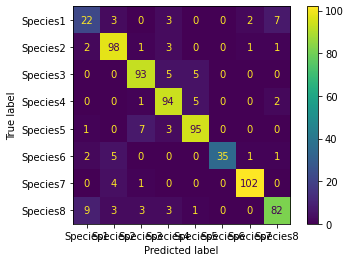

              precision    recall  f1-score   support

    Species1       0.61      0.59      0.60        37
    Species2       0.87      0.92      0.89       106
    Species3       0.88      0.90      0.89       103
    Species4       0.85      0.92      0.88       102
    Species5       0.90      0.90      0.90       106
    Species6       1.00      0.80      0.89        44
    Species7       0.96      0.95      0.96       107
    Species8       0.88      0.81      0.85       101

    accuracy                           0.88       706
   macro avg       0.87      0.85      0.86       706
weighted avg       0.88      0.88      0.88       706



In [ ]:
testModel(valid_gen, ensemble_model)

# AlexNet

In [ ]:
def build_alexNet_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    conv1 = tfkl.Conv2D(
        filters=96,
        kernel_size=(11, 11),
        strides=(4, 4),
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    #normalization1 = tfkl.BatchNormalization()(conv1)
    pool1 = tfkl.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(input_layer)

    conv2 = tfkl.Conv2D(
        filters=256,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    #normalization2 = tfkl.BatchNormalization()(conv2)
    pool2 = tfkl.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv2)

    conv3 = tfkl.Conv2D(
        filters=384,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    #normalization3 = tfkl.BatchNormalization()(conv3)
    conv4 = tfkl.Conv2D(
        filters=384,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv3)
    #normalization4 = tfkl.BatchNormalization()(conv4)
    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv4)
    #normalization5 = tfkl.BatchNormalization()(conv5)
    pool3 = tfkl.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool3)
    dropout1 = tfkl.Dropout(0.5, seed=seed)(flattening_layer)
    dense_layer1 = tfkl.Dense(units=4096, activation='relu', kernel_initializer=tfk.initializers.HeUniform(seed))(dropout1)
    dropout2 = tfkl.Dropout(0.5, seed=seed)(dense_layer1)
    dense_layer2 = tfkl.Dense(units=4096, activation='relu', kernel_initializer=tfk.initializers.HeUniform(seed))(dropout2)
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dense_layer2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.SGD(0.001), metrics='accuracy')

    # Return the model
    return model

In [ ]:
alexNet = build_alexNet_model(input_shape)
alexNet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 3)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 256)       19456     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 23, 23, 384)       132748

In [ ]:
import visualkeras

visualkeras.layered_view(alexNet)

ModuleNotFoundError: ignored

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_alexNet')

# Train the model
history = alexNet.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
178/178 [==============================] - ETA: 0s - loss: 18.0467 - accuracy: 0.1195

In [ ]:
# Save best epoch model
alexNet.save("savedModels/CNN_alexNet")

706/706 [==============================] - 3s 4ms/step


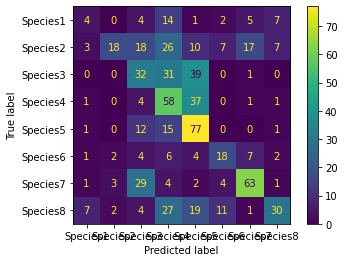

              precision    recall  f1-score   support

    Species1       0.22      0.11      0.15        37
    Species2       0.72      0.17      0.27       106
    Species3       0.30      0.31      0.30       103
    Species4       0.32      0.57      0.41       102
    Species5       0.41      0.73      0.52       106
    Species6       0.43      0.41      0.42        44
    Species7       0.66      0.59      0.62       107
    Species8       0.61      0.30      0.40       101

    accuracy                           0.42       706
   macro avg       0.46      0.40      0.39       706
weighted avg       0.49      0.42      0.41       706



In [ ]:
testModel(valid_gen, alexNet)

In [ ]:
testModel(valid_gen, alexNet)

In [ ]:
an = tfk.models.load_model("savedModels/CNN_alexNet")
an.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 22, 22, 96)        34944     
                                                                 
 batch_normalization_10 (Bat  (None, 22, 22, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 10, 10, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 10, 10, 256)       614656    
                                                                 
 batch_normalization_11 (Bat  (None, 10, 10, 256)      1024  

In [ ]:
an.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.SGD(0.0001), metrics='accuracy')

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_alexNet')

# Train the model
history = an.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 17s 185ms/step - loss: 12.2618 - accuracy: 0.4309 - val_loss: 1.5375 - val_accuracy: 0.4419
Epoch 2/200
89/89 [==============================] - 15s 171ms/step - loss: 12.0858 - accuracy: 0.4510 - val_loss: 1.7818 - val_accuracy: 0.3470
Epoch 3/200
89/89 [==============================] - 16s 180ms/step - loss: 11.9125 - accuracy: 0.4616 - val_loss: 1.7073 - val_accuracy: 0.3541
Epoch 4/200
89/89 [==============================] - 15s 171ms/step - loss: 11.9099 - accuracy: 0.4676 - val_loss: 1.5826 - val_accuracy: 0.3924
Epoch 5/200
89/89 [==============================] - 17s 193ms/step - loss: 11.7773 - accuracy: 0.4577 - val_loss: 1.6246 - val_accuracy: 0.3824
Epoch 6/200
89/89 [==============================] - 15s 169ms/step - loss: 11.8095 - accuracy: 0.4591 - val_loss: 1.7843 - val_accuracy: 0.3371
Epoch 7/200
89/89 [==============================] - 15s 171ms/step - loss: 11.9248 - accuracy: 0.4503 - val_loss: 1.7297 - val_ac

In [ ]:
# Save best epoch model
an.save("savedModels/CNN_alexNet_2")

706/706 [==============================] - 3s 4ms/step


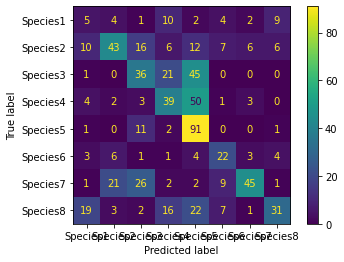

              precision    recall  f1-score   support

    Species1       0.11      0.14      0.12        37
    Species2       0.54      0.41      0.46       106
    Species3       0.38      0.35      0.36       103
    Species4       0.40      0.38      0.39       102
    Species5       0.40      0.86      0.54       106
    Species6       0.44      0.50      0.47        44
    Species7       0.75      0.42      0.54       107
    Species8       0.60      0.31      0.41       101

    accuracy                           0.44       706
   macro avg       0.45      0.42      0.41       706
weighted avg       0.49      0.44      0.44       706



In [ ]:
testModel(valid_gen, an)

In [ ]:
axn = tfk.models.load_model("savedModels/CNN_alexNet_2")
axn.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.SGD(0.00001), metrics='accuracy')

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_alexNet')

# Train the model
history = axn.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 17s 182ms/step - loss: 11.9879 - accuracy: 0.4464 - val_loss: 1.6275 - val_accuracy: 0.3895
Epoch 2/200
89/89 [==============================] - 15s 169ms/step - loss: 12.0116 - accuracy: 0.4552 - val_loss: 1.6874 - val_accuracy: 0.3725
Epoch 3/200
89/89 [==============================] - 16s 179ms/step - loss: 12.0533 - accuracy: 0.4450 - val_loss: 1.6992 - val_accuracy: 0.3683
Epoch 4/200
89/89 [==============================] - 15s 172ms/step - loss: 12.0870 - accuracy: 0.4545 - val_loss: 1.6880 - val_accuracy: 0.3711
Epoch 5/200
89/89 [==============================] - 16s 178ms/step - loss: 12.1210 - accuracy: 0.4348 - val_loss: 1.6857 - val_accuracy: 0.3711
Epoch 6/200
89/89 [==============================] - 15s 167ms/step - loss: 12.0142 - accuracy: 0.4633 - val_loss: 1.6972 - val_accuracy: 0.3654
Epoch 7/200
89/89 [==============================] - 16s 178ms/step - loss: 11.8964 - accuracy: 0.4563 - val_loss: 1.6966 - val_ac

In [ ]:
axn.save("savedModels/CNN_alexNet_3")

706/706 [==============================] - 3s 4ms/step


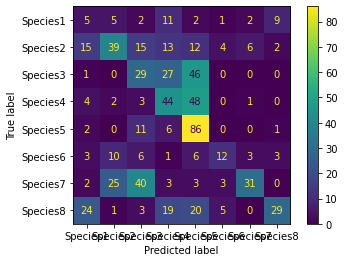

              precision    recall  f1-score   support

    Species1       0.09      0.14      0.11        37
    Species2       0.48      0.37      0.41       106
    Species3       0.27      0.28      0.27       103
    Species4       0.35      0.43      0.39       102
    Species5       0.39      0.81      0.52       106
    Species6       0.48      0.27      0.35        44
    Species7       0.72      0.29      0.41       107
    Species8       0.66      0.29      0.40       101

    accuracy                           0.39       706
   macro avg       0.43      0.36      0.36       706
weighted avg       0.46      0.39      0.38       706



In [ ]:
testModel(valid_gen, axn)